## IBM Data Scinece Captone Project 
**Name : Anamitra Saikia**

# The Battle of Neighborhoods

## 1. Introduction/Business Problem

  New York and Toronto are some of the most popular cities in the world. People migrate to other places in search of better opportunities and standards of living. A large number of people immigrate to these cities every year. Some people move from Toronto to new york and vice versa. A person moving from one city to another prefers to stay in a similar locality in the new place with similar facilities and venues in the locality, which helps to accommodate to the new place easily and faster. It also makes life easier. The given project compares different localities and presents the localities in both the cities which are similar in terms of venues and facilities available like shops, coffee shops, transportation, services, etc.


## 2. Data 


In [1]:
#importing required dependencies
!pip install matplotlib-venn
import json, requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
%matplotlib inline

### 2.1 Toronto Data

The data of postal codes, borough, and neighborhood are scrapped from the Wikipedia [[link]](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) using BeautifulSoup. After cleaning and formatting the dataset it is merged with Longitude and Latitude Dataset provided by Coursera [[Link]](https://cocl.us/Geospatial_data). With the help of Foursquare API, the venues nearby a given neighborhood is obtained.

In [2]:
#GET request and parsing
webpage = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(webpage, 'lxml')

#from table to dataframe
table_contents=[]
table = soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighbourhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df_toronto_postal = pd.DataFrame(table_contents)
df_toronto_postal['Borough']=df_toronto_postal['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

#grouping neighbourhoods with same postal codes

df_toronto_postal = df_toronto_postal.groupby(['PostalCode', 'Borough'], as_index=False).agg(lambda x: ", ".join(x))
df_toronto_postal['Neighbourhood'] = df_toronto_postal['Neighbourhood'].str.replace('/', ',')

df_toronto_postal.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [3]:
#importing the grospatial coordinates for postalcodes
url_csv = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv"
df_toronto_coord = pd.read_csv(url_csv , header = None )

#Formatting the dataset 
df_toronto_coord.rename(columns = {0:"PostalCode" , 1:"Latitude", 2:"Longitude"}, inplace = True)
df_toronto_coord.drop(0 , axis = 0 , inplace=True)
df_toronto_coord = df_toronto_coord.reset_index(drop=True)

df_toronto_coord.head()

,PostalCode,Latitude,Longitude
0,M1B,43.8066863,-79.1943534
1,M1C,43.7845351,-79.1604971
2,M1E,43.7635726,-79.1887115
3,M1G,43.7709921,-79.2169174
4,M1H,43.773136,-79.2394761


In [4]:
#Merging the postcode and coordinates datasets
df_toronto = pd.merge(df_toronto_postal, df_toronto_coord, on='PostalCode')
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.8066863,-79.1943534
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.7845351,-79.1604971
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7635726,-79.1887115
3,M1G,Scarborough,Woburn,43.7709921,-79.2169174
4,M1H,Scarborough,Cedarbrae,43.773136,-79.2394761


### 2.2 NewYork Data

The data of postal codes, borough, and neighborhood are obtained from the given source (Cognitive Class) [[link]](https://cocl.us/new_york_dataset). The data is in JSON which will be converted to a pandas data frame. The data of the borough, neighborhood, latitude, and longitude will be used in this project.

In [5]:
with open('newyork_data.json') as f:
    ny_json = json.load(f)

# relevant information is in 'features' key
ny_json = ny_json['features']
ny_json[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
#JSON to dataframe
cols = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
ny_df = pd.DataFrame(columns = cols)
for data in ny_json:
    borough = data['properties']['borough']
    neigh   = data['properties']['name']
    lat_lon = data['geometry']['coordinates'] # now it'll return list
    lon, lat = lat_lon[0], lat_lon[1]
    
    ny_df = ny_df.append({'Borough': borough,'Neighbourhood': neigh, 'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)
    
ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 3. Using FourSquare to get Venue Details

In [7]:
#Foursquare API credentials
CLIENT_ID = 'E5N5UATB2HKX1MBYVF42LL3KYKLDM5MXLQFS0UOHBQ5UIZIO' 
CLIENT_SECRET = 'ADH5SIRUH42B025QPXTTILOAABWFU5EDU4Z0EBDSQWLYMOYV'
VERSION = '20210602' 
LIMIT = 100

### 3.1 Functions to obtain venues 

In [8]:
def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [9]:
def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighbourhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    onehot_df['Neighbourhood'] = venues['Neighbourhood']
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighbourhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighbourhood', how = 'left')
    
    return onehot_coded_df

In [10]:
def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

### 3.2 Venues in Toronto

In [11]:
#Vanue details of toronto
try:
    df_to = pd.read_csv('Toronto_venue.csv')
except:
    df_to = return_venues_for_boroughs(df_toronto)
    df_to.fillna(0, inplace = True)
    df_to.to_csv('Toronto_venue.csv',  index_label = False)
print('Shape: ', df_to.shape)
df_to.head()

Shape:  (103, 326)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Pl

### 3.3 Venues in New York

In [12]:
#Venue details of New York City
try:
    df_ny = pd.read_csv('NewYork_venue.csv')
except:
    df_ny = return_venues_for_boroughs(ny_df)
    df_ny.fillna(0,  inplace = True)
    df_ny.to_csv('NewYork_venue.csv',  index_label = False)
print('Shape: ', df_ny.shape)
df_ny.head()

Shape:  (306, 493)


,Borough,Neighbourhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern R

<ul>
    <li> The number of unique venue types in Toronto is 321 </li>
    <li> The number of unique venue types in New York is 489 </li>
     
</ul>

## 4. Exploratory Data Analysis

In [13]:
#Finding common and unique venues
common = 0
diff_in_NY = 0

for i in df_ny.columns[4:]:
    if i in df_to.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are       :{}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue categories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df_to.columns[5:])-common))


Number of common venue categories in both data are       :293
Number of different venue categories in New York city are: 196
Number of different venue categories in Toronto city are : 28


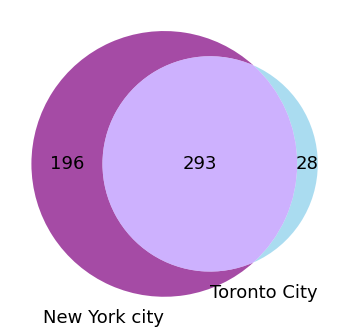

In [14]:
c1 = set(df_ny.columns[4:])
c2 = set(df_to.columns[5:])
plt.figure(figsize = (6,6))
venndiag = venn2([set(c1), set(c2)], set_labels = ['New York city', 'Toronto City'],set_colors=('purple', 'skyblue'), alpha = 0.7)
for text in venndiag.set_labels:
    text.set_fontsize(18)
for text in venndiag.subset_labels:
    text.set_fontsize(18)
plt.show()

In [15]:
#Excluding non common venues
comm_col = []
for i in df_ny.columns[4:]:
    if i in df_to.columns[5:]:
        comm_col.append(i)

col1 = list(df_ny.columns[0:4]) + comm_col
col2 = list(df_to.columns[0:5]) + comm_col
df_ny = df_ny.loc[:, col1]
df_to = df_to.loc[:, col2]
print('After reomoving non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df_ny.shape, df_to.shape))

After reomoving non-common shape of New York: (306, 297), and shape of Toronto is: (103, 298)


## 5. Similar locations

**Cosine Similarity** is used for finding the most similar location in the other city. Cosine similarity is a metric used to determine how similar the documents are irrespective of their size.

The top 7 most similar location will be selected on the basis of user details including latitude, longitude and the venues near the location.

In [16]:
def return_ordered_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

In [17]:
index = df_ny.loc[(df_ny['Borough'] == 'Bronx') 
                & (df_ny['Neighbourhood'] == 'Riverdale')].index.values.astype(int)[0]
lat = df_ny.loc[index]['Latitude']
lon = df_ny.loc[index]['Longitude']
print('Index    :{}\nLatitude : {}\nLongitude: {}'.format(index, lat, lon))

Index    :258
Latitude : 40.890834493891305
Longitude: -73.9125854610857


In [18]:
ny_data = df_ny.loc[:,comm_col] 
toronto_data = df_to.loc[:,comm_col] 

# converting into numpy ndarray
X1 = ny_data.values
X2 = toronto_data.values
print('Shape of X1: {}\nShape of X2: {}'.format(X1.shape, X2.shape))

Shape of X1: (306, 293)
Shape of X2: (103, 293)


**Cosine Similarity to find similar boroughs**

In [19]:
a = np.matmul(X1[index], X2.T)
aa = np.argsort(-a)[0:7] 
my_borough = df_to.iloc[aa, :]
print(my_borough.shape)
my_borough.head()

(7, 298)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Thea

In [20]:
c = return_ordered_num(7)

current_location_popup = 'Bronx, Riverdale, New York'
label1 = folium.Popup(current_location_popup, parse_html=True)

my_map = folium.Map(location = [lat, lon], zoom_start = 6)
folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                    popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                    fill = True, tooltip = 'current location').add_to(my_map)

for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                     my_borough['Neighbourhood'], c):
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                  tooltip = priority, parse_html=False).add_to(my_map)
    
my_map

### COMBINED FUNCTION 

In [21]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    ny_data = df_ny.iloc[:,4:]
    toronto_data = df_to.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df_ny.loc[(df_ny['Borough'] == current_borough) 
                        & (df_ny['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df_ny.loc[index]['Latitude']
        lon = df_ny.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df_to.loc[(df_to['Borough'] == current_borough) 
                & (df_to['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df_to.loc[index]['Latitude']
        lon = df_to.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df_to.iloc[aa, :]
    else:
        my_borough = df_ny.iloc[aa, :]
   
    # for tooltip of map
    c = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label1 = folium.Popup(current_location_popup, parse_html=True)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                        popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                        fill = True, tooltip = 'current location').add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                         my_borough['Neighbourhood'], c):
        label = folium.Popup(label, parse_html=True)
        folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                      tooltip = priority, parse_html=False).add_to(my_map)  

    return my_map

In [22]:
print("Enter the current City")
current_city = input("City: ")
print("Enter the current Borough")
current_borough = input("Borough: ")
print("Enter the current Neigbourhood")
current_neigh = input("Neigbourhood: ")
most_similar_borough(current_city, current_borough,
                     current_neigh, n_most_similar = 5)

Enter the current City
City: New York
Enter the current Borough
Borough: Bronx
Enter the current Neigbourhood
Neigbourhood: Riverdale
